# Introduction

This notebook was used in order to create the **"Naive late-fusion + Fixed location" curve in Figure 3 and row in TABLE II**.

Note that a lot of code is copy-pasted across notebooks, so you may find some functionality implemented here that is not used, for instance the network is implemented in a way to support late-fusion, which is not used.

In [1]:
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Font which got unicode math stuff.
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Much better than plt.subplots()
from mpl_toolkits.axes_grid1 import ImageGrid

# https://github.com/ipython/ipython/issues/7270#issuecomment-355276432
mpl.interactive(False)

In [3]:
import wheelchAI.utils as u

In [4]:
import lbtoolbox.util as lbu

In [5]:
from ipywidgets import interact, IntSlider, FloatSlider
import ipywidgets

# Data loading

In [6]:
from os.path import join as pjoin
from glob import glob

**CAREFUL**: `scan` goes right-to-left, i.e. first array value corresponds to "rightmost" laser point. Positive angle is left, negative angle right.

In [7]:
LABELDIR = DATADIR = "/fastwork/data/DROW-data/"
train_names = [f[:-4] for f in glob(pjoin(DATADIR, 'train', '*.csv'))]
val_names = [f[:-4] for f in glob(pjoin(DATADIR, 'val', '*.csv'))]
te_names = [f[:-4] for f in glob(pjoin(DATADIR, 'test', '*.csv'))]

In [8]:
tr = u.Dataset(train_names, DATADIR, LABELDIR)

In [9]:
va = u.Dataset(val_names, DATADIR, LABELDIR)

In [8]:
WIN_KW = dict(ntime=5, nsamp=48, odom=False, repeat_before=True)

In [11]:
%timeit u.get_batch(tr, bs=1024, **WIN_KW)

333 ms ± 6.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
batcher = u.BackgroundFunction(u.get_batch, 5, data=tr, bs=1024, **WIN_KW)

# Model definition

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import lbtoolbox.pytorch as lbt

torch.backends.cudnn.benchmark = True  # Run benchmark to select fastest implementation of ops.
GPU=0  # This is the GPU index, use `False` for CPU-only.

In [11]:
def apply_dim(fn, *inputs, dim=0):
    return torch.stack([fn(*(a[0] for a in args)) for args in zip(*(inp.split(1, dim=dim) for inp in inputs))], dim=dim)

def apply_dim_keepdim(fn, *inputs, dim=0):
    return torch.cat([fn(*(a for a in args)) for args in zip(*(inp.split(1, dim=dim) for inp in inputs))], dim=dim)

In [12]:
def apply_sum2(fn, x):
    (B, T), R = x.shape[:2], x.shape[2:]
    x2 = x.view(B*T, 1, *R)
    x2 = fn(x2)
    x = x2.view(B, T, *x2.shape[1:])
    return torch.sum(x, dim=1)

In [13]:
def apply_sum2(fn, x):
    (B, T), R = x.shape[:2], x.shape[2:]
    x2 = x.view(B*T, 1, *R)
    x2 = fn(x2)
    x = x2.view(B, T, *x2.shape[1:])
    return torch.sum(x, dim=1)

In [14]:
class DROWNet3LF2p(nn.Module):
    def __init__(self, snip_len, thin_fact, dropout=0.5, *a, **kw):
        super(DROWNet3LF2p, self).__init__(*a, **kw)
        #         >>> m = weight_norm(nn.Linear(20, 40), name='weight', dim=???)
        self.dropout = dropout
        self.conv1a = nn.Conv1d(  1,  64, kernel_size=3, padding=1)
        self.bn1a   = nn.BatchNorm1d( 64)
        self.conv1b = nn.Conv1d( 64,  64, kernel_size=3, padding=1)
        self.bn1b   = nn.BatchNorm1d( 64)
        self.conv1c = nn.Conv1d( 64, 128, kernel_size=3, padding=1)
        self.bn1c   = nn.BatchNorm1d(128)
        self.conv2a = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn2a   = nn.BatchNorm1d(128)
        self.conv2b = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.bn2b   = nn.BatchNorm1d(128)
        self.conv2c = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn2c   = nn.BatchNorm1d(256)
        self.conv3a = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn3a   = nn.BatchNorm1d(256)
        self.conv3b = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn3b   = nn.BatchNorm1d(256)
        self.conv3c = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn3c   = nn.BatchNorm1d(512)
        self.conv4a = nn.Conv1d(512, 256, kernel_size=3, padding=1)
        self.bn4a   = nn.BatchNorm1d(256)
        self.conv4b = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn4b   = nn.BatchNorm1d(128)
        self.conv4p = nn.Conv1d(128, 4, kernel_size=1)  # probs
        self.conv4v = nn.Conv1d(128, 2, kernel_size=1)  # vote

        self.reset_parameters()

    def forward(self, x):
        def trunk_forward(x):
            x = F.leaky_relu(self.bn1a(self.conv1a(x)), 0.1)
            x = F.leaky_relu(self.bn1b(self.conv1b(x)), 0.1)
            x = F.leaky_relu(self.bn1c(self.conv1c(x)), 0.1)
            x = F.max_pool1d(x, 2)  # 24
            x = F.dropout(x, p=self.dropout, training=self.training)

            x = F.leaky_relu(self.bn2a(self.conv2a(x)), 0.1)
            x = F.leaky_relu(self.bn2b(self.conv2b(x)), 0.1)
            x = F.leaky_relu(self.bn2c(self.conv2c(x)), 0.1)
            x = F.max_pool1d(x, 2)  # 12
            x = F.dropout(x, p=self.dropout, training=self.training)
            return x

        #x = apply_sum(trunk_forward, x, dim=1)
        x = apply_sum2(trunk_forward, x)

        x = F.leaky_relu(self.bn3a(self.conv3a(x)), 0.1)
        x = F.leaky_relu(self.bn3b(self.conv3b(x)), 0.1)
        x = F.leaky_relu(self.bn3c(self.conv3c(x)), 0.1)
        x = F.max_pool1d(x, 2)  # 6
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = F.leaky_relu(self.bn4a(self.conv4a(x)), 0.1)
        x = F.leaky_relu(self.bn4b(self.conv4b(x)), 0.1)
        x = F.avg_pool1d(x, 6)
        logits = self.conv4p(x)
        votes = self.conv4v(x)
        return logits[:,:,0], votes[:,:,0]  # Due to the arch, output has spatial size 1, so we [0] it.

    def reset_parameters(self):
        lbt.init(self.conv1a, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv1b, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv1c, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv2a, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv2b, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv2c, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv3a, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv3b, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv3c, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv4a, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv4b, lambda t: nn.init.kaiming_normal(t, a=0.1), 0)
        lbt.init(self.conv4p, lambda t: nn.init.constant(t, 0), 0)
        lbt.init(self.conv4v, lambda t: nn.init.constant(t, 0), 0)
        nn.init.constant(self.bn1a.weight, 1)
        nn.init.constant(self.bn1b.weight, 1)
        nn.init.constant(self.bn1c.weight, 1)
        nn.init.constant(self.bn2a.weight, 1)
        nn.init.constant(self.bn2b.weight, 1)
        nn.init.constant(self.bn2c.weight, 1)
        nn.init.constant(self.bn3a.weight, 1)
        nn.init.constant(self.bn3b.weight, 1)
        nn.init.constant(self.bn3c.weight, 1)
        nn.init.constant(self.bn4a.weight, 1)
        nn.init.constant(self.bn4b.weight, 1)

In [15]:
net = lbt.maybe_cuda(DROWNet3LF2p(WIN_KW['ntime'], 2.5), GPU)
lbt.count_parameters(net)

1518918

In [19]:
with torch.no_grad():
    logits, votes = net(Variable(lbt.maybe_cuda(torch.from_numpy(batcher()[0]), GPU)))
logits.data.shape, votes.data.shape

(torch.Size([1024, 4]), torch.Size([1024, 2]))

In [20]:
_dummy_X, _, _ = u.get_batch(tr, 450, **WIN_KW)

def _fwd(net, GPU):
    with torch.no_grad():
        logits, votes = net(Variable(lbt.maybe_cuda(torch.from_numpy(_dummy_X), GPU), requires_grad=False))
        return logits.data.cpu(), votes.data.cpu()

In [17]:
net.eval();

In [22]:
%timeit _fwd(net, GPU)

17.3 ms ± 5.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**NOTE**: Wrong timing cuz GPU busy!!

# Training

In [16]:
import lbtoolbox.plotting as lbplt

In [24]:
def plottrain_loss(ax_xent, ax_votes):
    ax_xent.plot(np.array(xent_avg_losses).flatten())
    ax_xent.plot(7500*(0.5 + np.arange(len(xent_avg_losses))), np.mean(xent_avg_losses, axis=-1))
    ax_xent.set_yscale('log')
    ax_xent.set_ylim(top=2e-1)
    ax_votes.plot(np.array(offs_avg_losses).flatten())
    ax_votes.plot(7500*(0.5 + np.arange(len(xent_avg_losses))), np.mean(offs_avg_losses, axis=-1))
    ax_votes.set_yscale('log')
    ax_votes.set_ylim(top=2e-1)

In [25]:
def plottrain1():
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    plottrain_loss(*axs)
    return fig

## Actual start

In [ ]:
opt = optim.Adam(net.parameters(), amsgrad=True)
xent_losses = []
offs_losses = []
xent_avg_losses = []
offs_avg_losses = []
e, name = 50, "final-WNet3xLF2p-T5-odom=False"
net.reset_parameters()

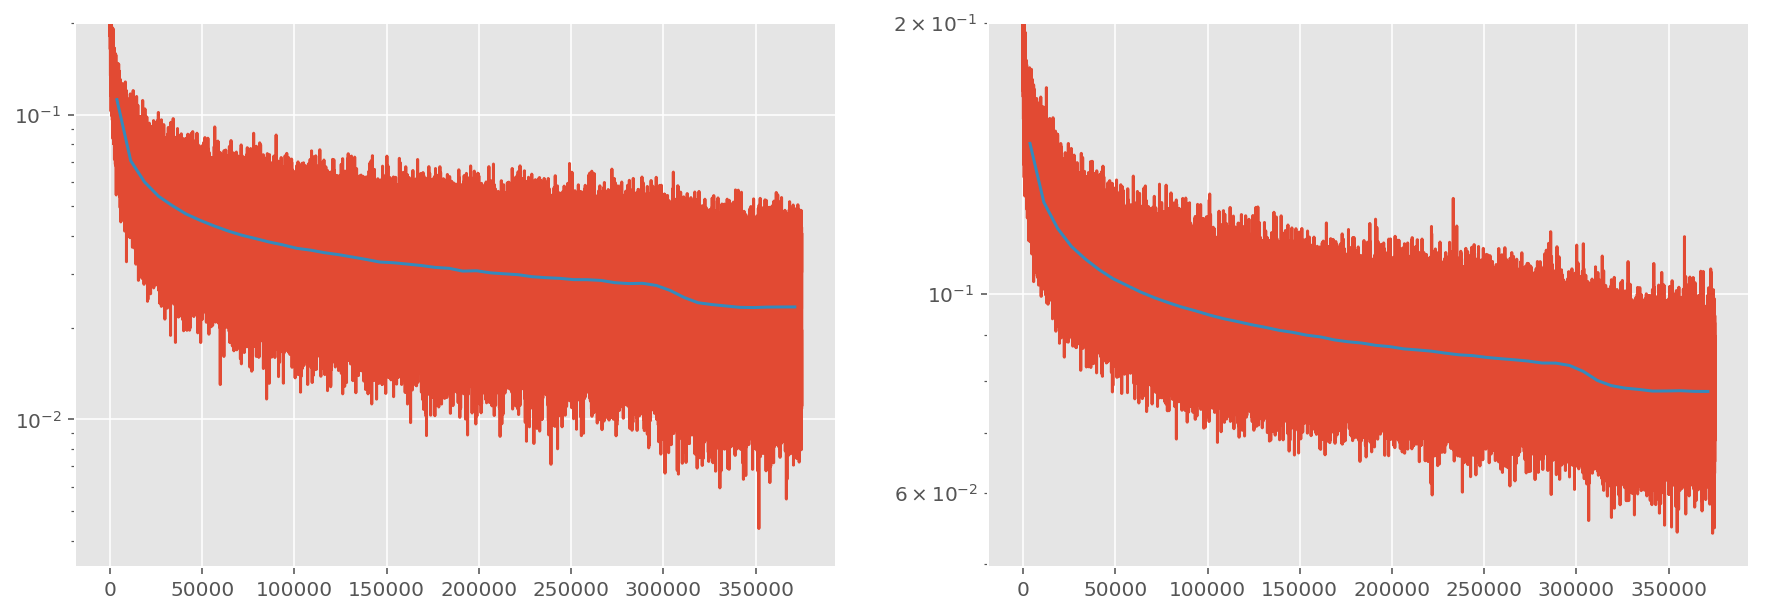

In [29]:
with lbu.Uninterrupt() as un:
  net.train()
  for e in range(e, 50):
    torch.save({'model': net.state_dict(), 'optim': opt.state_dict()},
               '/fastwork/beyer/dumps/DROW/{}-{:.0f}ep.pth.tar'.format(name, e))

    if un.interrupted:
        break

    for i in range(7500):
        Xb, yb_conf, yb_offs = batcher()

        # Apply target noise
        tgt_noise = np.exp(np.random.randn(*yb_offs.shape).astype(np.float32)/20)
        yb_offs = yb_offs*tgt_noise

        # Random left-right flip. Of whole batch for convenience, but should be the same as individuals.
        if np.random.rand() < 0.5:
            Xb = np.array(Xb[:,:,::-1])  # PyTorch doesn't currently support negative strides.
            yb_offs = np.c_[-yb_offs[:,0], yb_offs[:,1]]  # Sure to get a copy, batched could give us a view!

        v_X      = Variable(lbt.maybe_cuda(torch.from_numpy(Xb), GPU))
        v_y_conf = Variable(lbt.maybe_cuda(torch.from_numpy(yb_conf), GPU), requires_grad=False)
        v_y_offs = Variable(lbt.maybe_cuda(torch.from_numpy(yb_offs), GPU), requires_grad=False)

        opt.zero_grad()

        logits, votes = net(v_X)
        xent = F.cross_entropy(logits, v_y_conf, reduce=True)
        xent_losses.append(xent.data.cpu().numpy())

        loss = xent.mean()

        # Need to special-case batches without any vote labels, because mean of empty is nan.
        if np.sum(yb_conf) > 0:
            offs = F.mse_loss(votes, v_y_offs, reduce=False)  # This is really just (a - b)²
            offs = torch.sqrt(torch.masked_select(torch.sum(offs, 1), v_y_conf.ne(0)))
            offs_losses.append(offs.data.cpu().numpy())
            loss += offs.mean()
        else:
            offs_losses.append(np.array([]))

        loss.backward()

        # Total number of iterations/updates
        for group in opt.param_groups:
            group['lr'] = lbu.expdec(e+i/7500, 40, 1e-3, 50, 1e-6)
        opt.step()

        if i > 0 and i % 25 == 0:
            print('\r[{:.2f} ({}/{})]: Loss: xent={:.4f} offs={:.4f} | Q-fill={:.1%}  '.format(
                e+i/7500, i, 7500,
                np.mean(xent_losses[-100:]), np.nanmean(list(map(np.mean, offs_losses[-100:]))),
                batcher.fill_status(normalize=True),
            ), end='', flush=True)

    # To avoid OOM errors on long runs
    xent_avg_losses.append(np.array([np.mean(x) for x in xent_losses]))
    offs_avg_losses.append(np.array([np.mean(o) for o in offs_losses]))
    xent_losses.clear()
    offs_losses.clear()

    lbplt.liveplot(plottrain1)

torch.save({'model': net.state_dict(), 'optim': opt.state_dict()},
           '/fastwork/beyer/dumps/DROW/{}-{:.0f}ep.pth.tar'.format(name, e+1))

In [21]:
load = torch.load('/fastwork/beyer/dumps/DROW/{}-{:.0f}ep.pth.tar'.format(name, e),
                  map_location={'cuda:1':'cuda:0'})
net.load_state_dict(load['model'])
opt.load_state_dict(load['optim'])

# Evaluation

In [22]:
import pickle

In [23]:
def get_scan(va, iseq, iscan, ntime, nsamp, repeat_before, **cutout_kw):
    scan = va.scans[iseq][iscan]
    Xb = np.empty((len(scan), ntime, nsamp), np.float32)
    
    assert repeat_before, "Don't know what to do if not repeat before?!"

    # Prepend the exact same scan/odom for the first few where there's no history.
    if iscan-ntime+1 < 0:
        scans = np.array([va.scans[iseq][0]]*abs(iscan-ntime+1) + [va.scans[iseq][i] for i in range(iscan+1)])
        odoms = np.array([va.odoms[iseq][0]]*abs(iscan-ntime+1) + [va.odoms[iseq][i] for i in range(iscan+1)])
    else:
        scans = va.scans[iseq][iscan-ntime+1:iscan+1]
        odoms = va.odoms[iseq][iscan-ntime+1:iscan+1]

    for ipt in range(len(scan)):
        u.cutout(scans, odoms, ipt, out=Xb[ipt], nsamp=nsamp, **cutout_kw)

    return Xb

def forward(net, xb):
    net.eval()
    with torch.no_grad():
        logits, votes = net(Variable(lbt.maybe_cuda(torch.from_numpy(xb), GPU)))
        return F.softmax(logits, dim=-1).data.cpu().numpy(), votes.data.cpu().numpy()

def forward_all(net, va, **get_scan_kw):
    all_confs, all_votes = [], []
    nseq = len(va.detsns)
    for iseq in range(nseq):
        ndet = len(va.detsns[iseq])
        for idet in range(ndet):
            print('\r[{}/{} | {}/{}]           '.format(1+iseq, nseq, 1+idet, ndet), flush=True, end='')
            confs, votes = forward(net, get_scan(va, iseq, va.idet2iscan[iseq][idet], **get_scan_kw))
            all_confs.append(confs)
            all_votes.append(votes)
    return np.array(all_confs), np.array(all_votes)

## On val

In [32]:
pred_yva_conf, pred_yva_offs = forward_all(net, va, **WIN_KW)

[30/30 | 20/20]               

In [33]:
_seqs, _scans, _wcs, _was, _wps = u.linearize(va.scansns, va.scans, va.detsns, va.wcdets, va.wadets, va.wpdets)
_scans = np.array(_scans)

Compute and dump the predictions on the validation set in order to use them in our hyperparameter tuning setup (which is not published because very specific to our lab)

In [34]:
x, y = u._prepare_prec_rec_softmax(_scans, pred_yva_offs)

In [35]:
pickle.dump([x, y, pred_yva_conf, _wcs, _was, _wps], open('/home/hermans/drow_votes/' + name + ".pkl", "wb"))

In [36]:
name

'final-WNet3xLF2p-T5-odom=False'

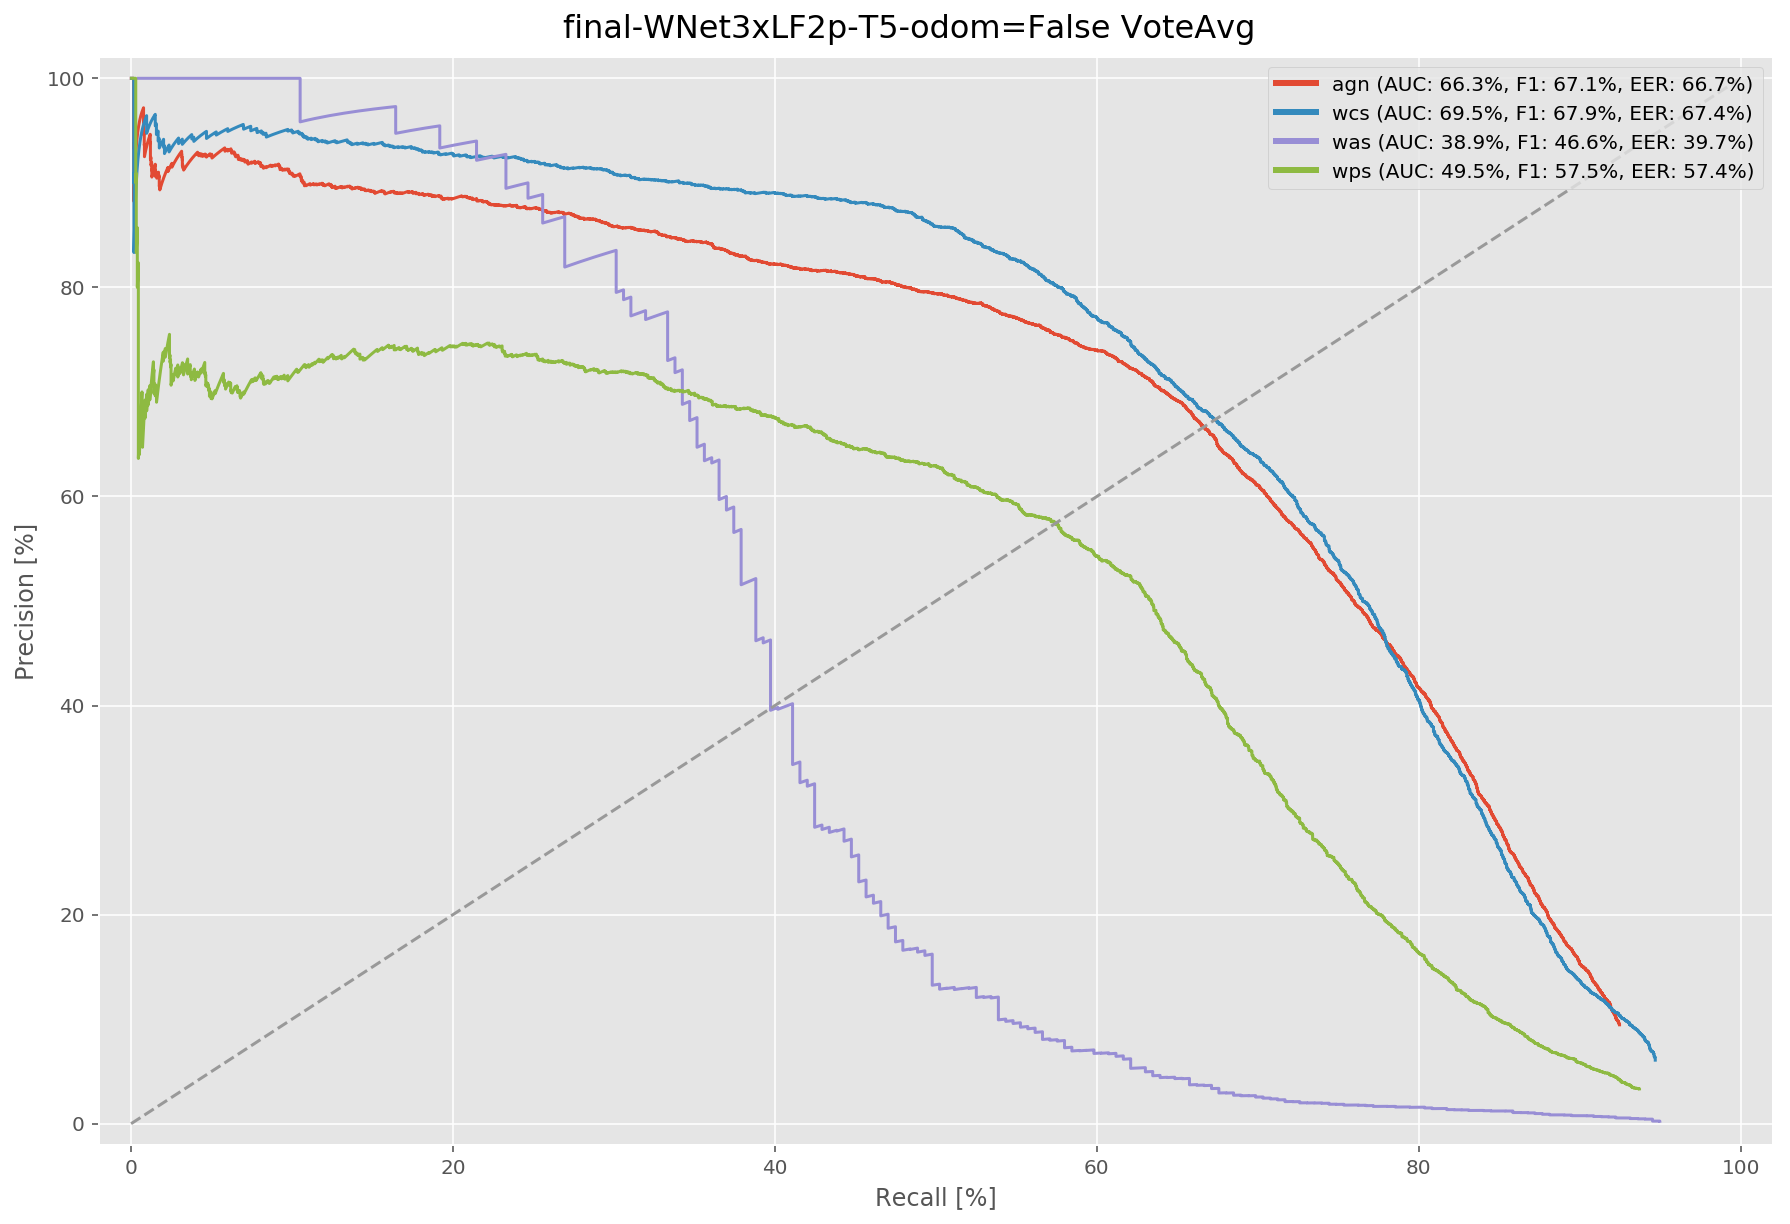

In [37]:
results = u.comp_prec_rec_softmax(_scans, _wcs, _was, _wps, pred_yva_conf, pred_yva_offs,
                                  blur_win=5, blur_sigma=1, weighted_avg=False)

fig, ax = u.plot_prec_rec(*results, title=name + " VoteAvg")
plt.close(fig)
fig

## On Test

In [24]:
te = u.Dataset(te_names, DATADIR, LABELDIR)

_seqs_te, _scans_te, _wcs_te, _was_te, _wps_te = u.linearize(te.scansns, te.scans, te.detsns, te.wcdets, te.wadets, te.wpdets)
_scans_te = np.array(_scans_te)

In [25]:
pred_yte_conf, pred_yte_offs = forward_all(net, te, **WIN_KW)

[5/5 | 340/340]           

### TABLE II, "Late-fusion + Fixed location" row and Figure 3, line - - -

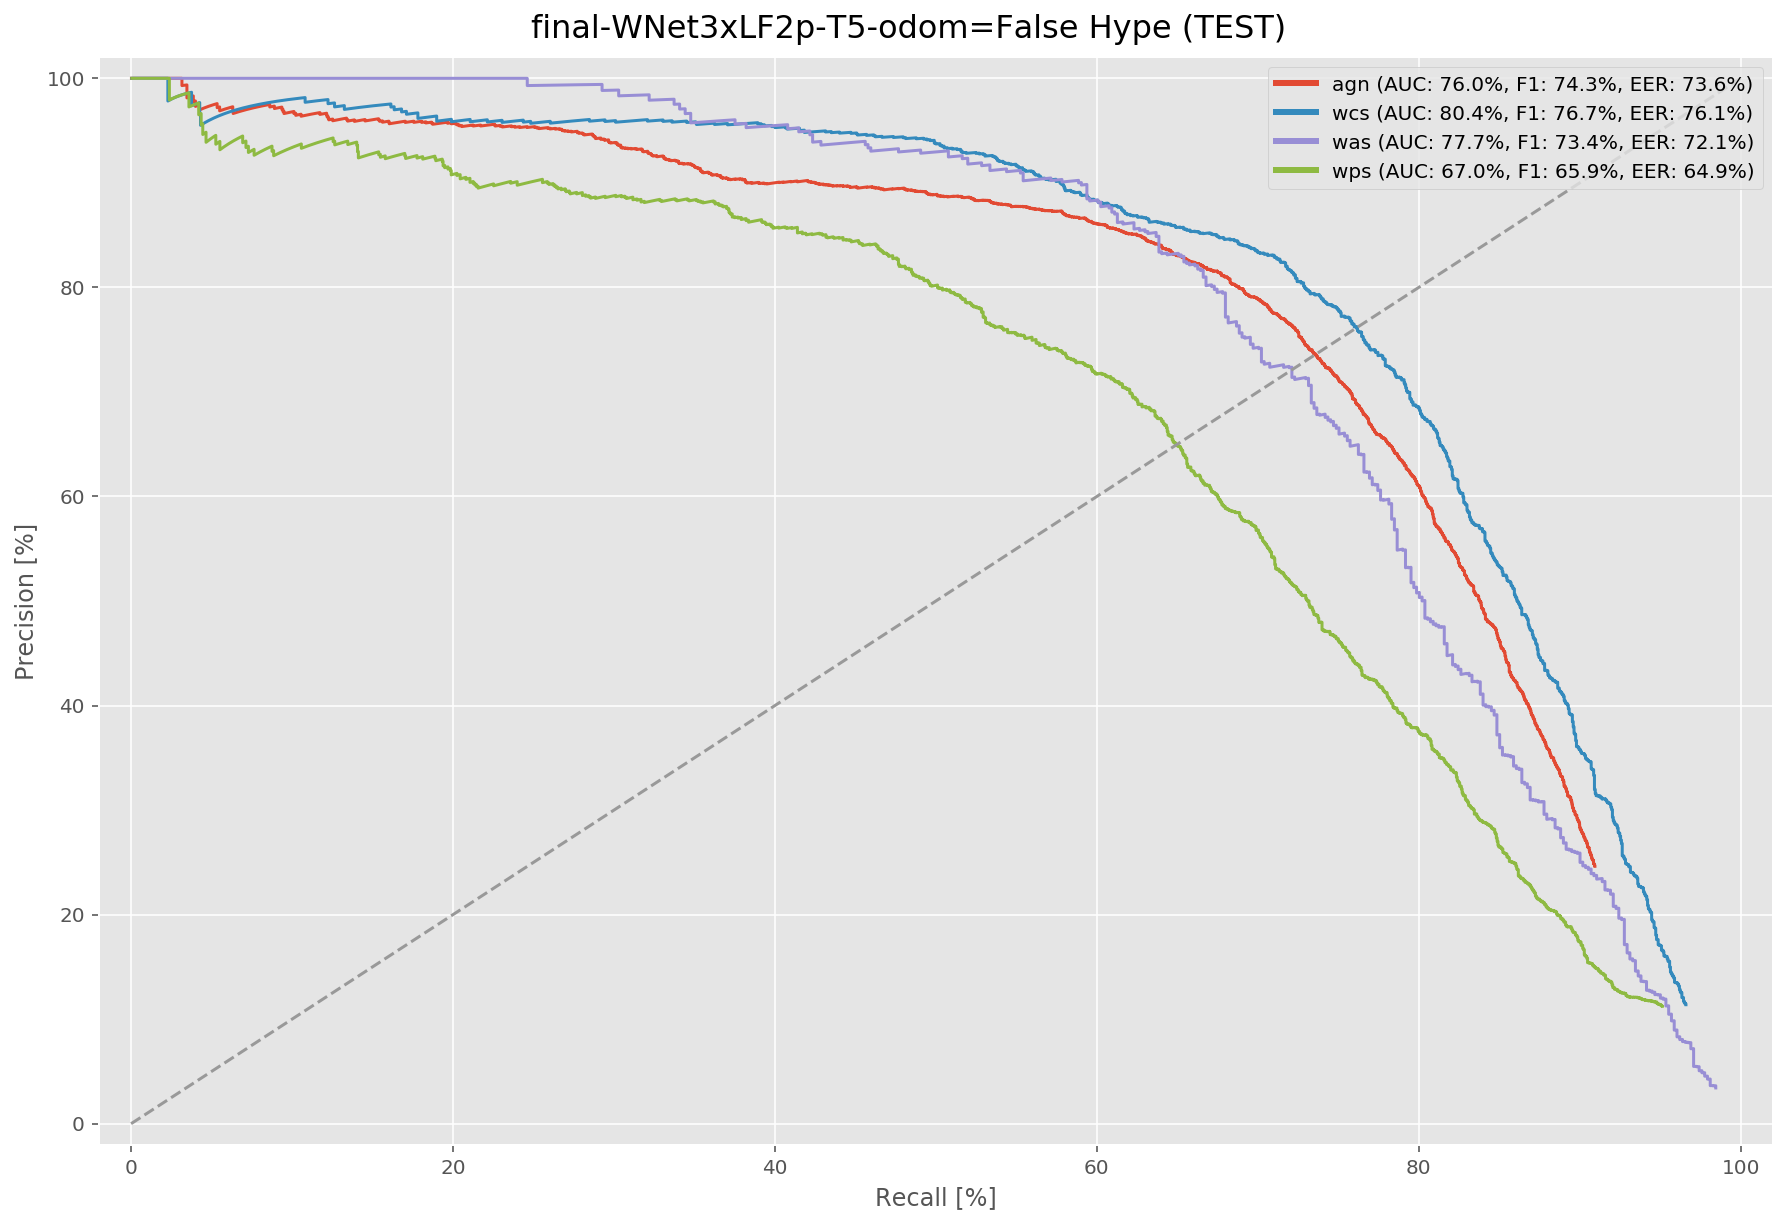

{'blur_sigma': 0.9768978358834013, 'blur_win': 5, 'bin_size': 0.11457119732048134, 'vote_collect_radius': 1.5762846923341851, 'min_thresh': 0.0013154609060437876, 'class_weights': [0.7239157089973238, 0.8727648198561551, 0.3719358462108377]}


In [26]:
import json
from os.path import join as pjoin
with open(pjoin('/home/hermans/drow_votes', name + '.json')) as f:
    _kw = json.loads(f.read())

results_te = u.comp_prec_rec_softmax(_scans_te, _wcs_te, _was_te, _wps_te, pred_yte_conf, pred_yte_offs, **_kw)

plt.close()
fig, ax = u.plot_prec_rec(*results_te, title=name + " Hype (TEST)")
plt.show(fig)
print(_kw)

In [ ]:
for i, cls in enumerate(['wd', 'wc', 'wa', 'wp']):
    u.dump_paper_pr_curves(
        '/home/beyer/academic/drower9k/iros18_laser_people_detection/data/pr_curves/' + name + '_' + cls,
        results_te[i][1], results_te[i][0])